In [1]:
from functools import partial
import logging
import os
import sys
import jax
import haiku as hk
import numpy as np
import dask
import xarray as xr
from tqdm import tqdm

from graphcast import rollout

from graphufs.training import construct_wrapped_graphcast
from graphufs.batchloader import MPIExpandedBatchLoader
from graphufs.datasets import Dataset
from graphufs.inference import swap_batch_time_dims, store_container
from graphufs.mpi import MPITopology

In [2]:
def predict(
    params,
    state,
    emulator,
    batchloader,
    mpi_topo,
) -> xr.Dataset:

    @hk.transform_with_state
    def run_forward(inputs, targets_template, forcings):
        predictor = construct_wrapped_graphcast(emulator)
        return predictor(inputs, targets_template=targets_template, forcings=forcings)

    def with_params(fn):
        return partial(fn, params=params, state=state)

    def drop_state(fn):
        return lambda **kw: fn(**kw)[0]

    logging.info("JIT Compiling Predict")
    gc = drop_state(with_params(jax.jit(run_forward.apply)))
    logging.info("Done Compiling Predict")

    hours = int(emulator.forecast_duration.value / 1e9 / 3600)
    pname = f"{emulator.local_store_path}/inference/{batchloader.dataset.mode}/graphufs.{hours}h.zarr"
    tname = f"{emulator.local_store_path}/inference/{batchloader.dataset.mode}/replay.{hours}h.zarr"

    n_steps = len(batchloader)
    with open(mpi_topo.progress_file, "a") as f:
        progress_bar = tqdm(total=n_steps, ncols=80, desc="Processing", file=f)
        for k, (inputs, targets, forcings) in enumerate(batchloader):

            if inputs is not None:
                # retrieve and drop t0
                inittimes = inputs.datetime.isel(time=-1).values
                inputs = inputs.drop_vars("datetime")
                targets = targets.drop_vars("datetime")
                forcings = forcings.drop_vars("datetime")

                # predictions have dims [batch, time (aka forecast_time), level, z_l, lat, lon]
                predictions = rollout.chunked_prediction(
                    gc,
                    rng=jax.random.PRNGKey(0),
                    inputs=inputs,
                    targets_template=np.nan * targets,
                    forcings=forcings,
                )

                # perform output transform, e.g. exp( log_spfh )
                for key, mapping in emulator.output_transforms.items():
                    with xr.set_options(keep_attrs=True):
                        predictions[key] = mapping(predictions[key])
                        targets[key] = mapping(targets[key])

                # Add t0 as new variable, and swap out for logical sample/batch index
                # swap dims to be [time (aka initial condition time), lead_time (aka forecast_time), level, z_l, lat, lon]
                predictions = swap_batch_time_dims(predictions, inittimes)
                targets = swap_batch_time_dims(targets, inittimes)

                # Store to zarr one batch at a time
                if k == 0:
                    if mpi_topo.is_root:
                        store_container(pname, predictions, time=batchloader.initial_times, mode="w")
                        store_container(tname, targets, time=batchloader.initial_times, mode="w")
                    mpi_topo.comm.Barrier()

                # Store to zarr
                spatial_region = {d: slice(None, None) for d in predictions.dims if d != "time"}
                rank_idx = mpi_topo.rank*batchloader.data_per_device
                st = k*batchloader.batch_size + rank_idx
                ed = st + batchloader.data_per_device
                region = {
                    "time": slice(st, ed),
                    **spatial_region,
                }
                predictions.to_zarr(pname, region=region)
                targets.to_zarr(tname, region=region)

            progress_bar.update()
        progress_bar.close()

In [3]:
def inference(Emulator):

    topo = MPITopology(log_dir=f"{Emulator.local_store_path}/logs/inference")
    emulator = Emulator(mpi_rank=topo.rank, mpi_size=topo.size)

    vds = Dataset(
        emulator,
        mode="validation",
        preload_batch=False,
    )

    validator = MPIExpandedBatchLoader(
        vds,
        batch_size=emulator.batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=0,
        max_queue_size=1,
        sample_stride=emulator.sample_stride,
        mpi_topo=topo,
    )
    
    #assert validator.data_per_device == 1

    # setup weights
    logging.info(f"Reading weights ...")
    ckpt_id = emulator.evaluation_checkpoint_id if emulator.evaluation_checkpoint_id is not None else emulator.num_epochs
    params, state = emulator.load_checkpoint(id=ckpt_id)

    predict(
        params=params,
        state=state,
        emulator=emulator,
        batchloader=validator,
        mpi_topo=topo,
    )

    validator.shutdown()
    logging.info("Done running inference")

In [5]:
sys.path.append("/global/homes/n/nagarwal/graph-ufs/prototypes/atm_only/")
from R0.config import AtmEvaluator as Emulator

In [6]:
inference(Emulator)

FileNotFoundError: [Errno 2] No such file or directory: '/pscratch/sd/n/nagarwal/atm-only/notebooks/models/model_80.npz'

## Surface Pressure

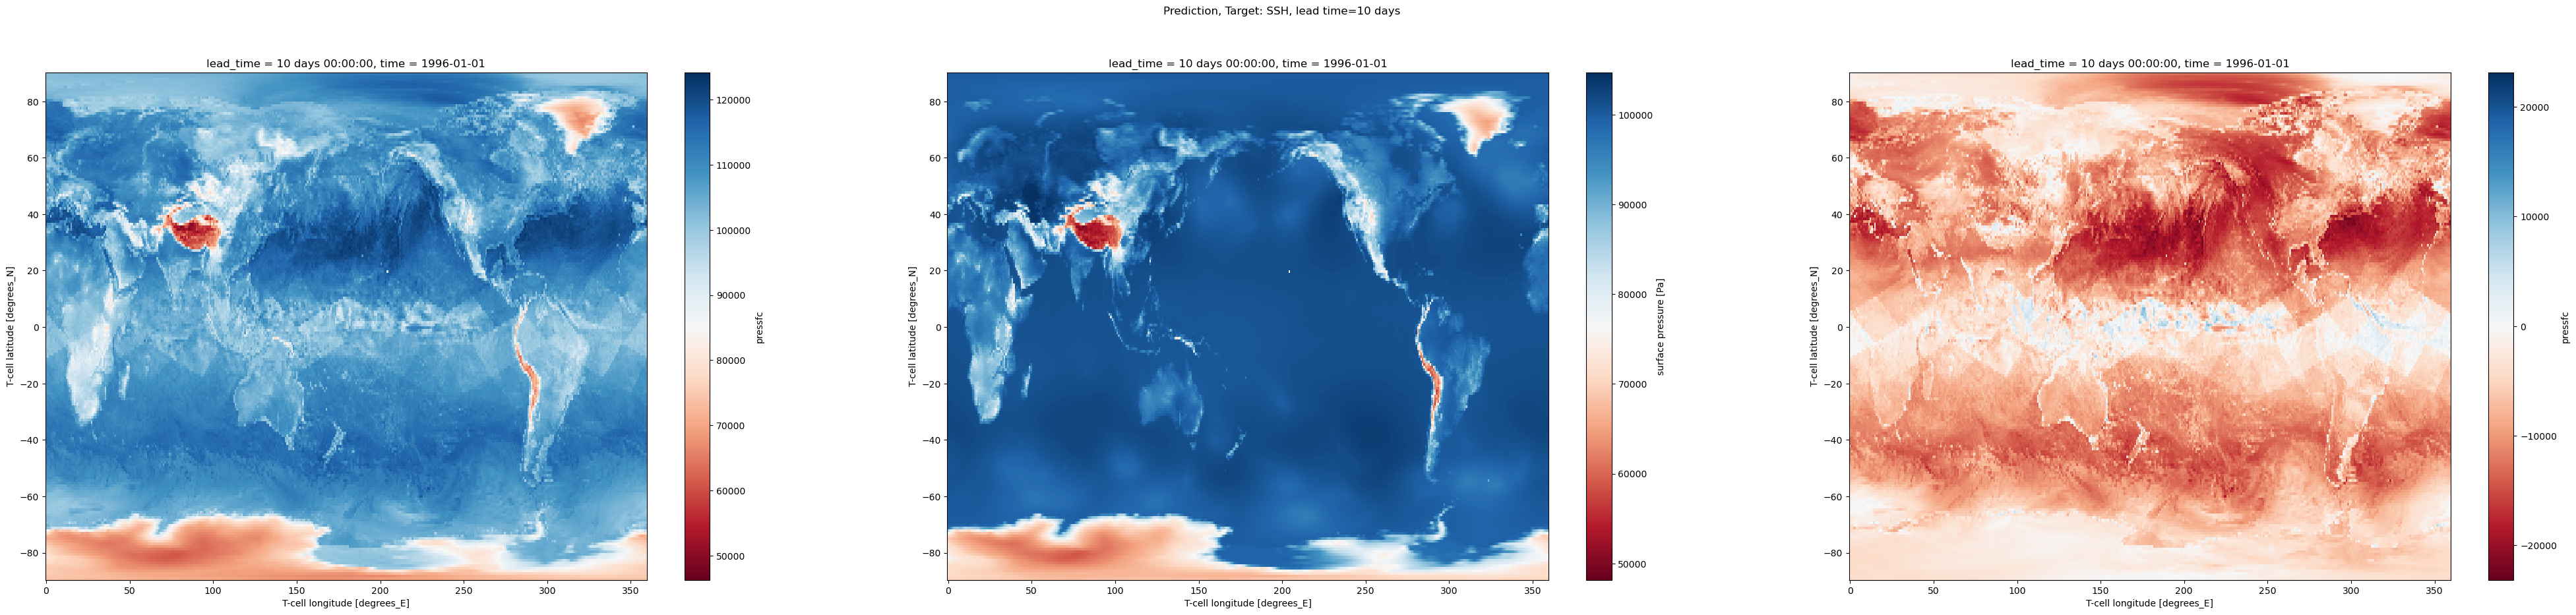

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(50,10))
predictions.pressfc.isel(time=0, lead_time=-1).plot(ax=ax[0], cmap="RdBu")
targets.pressfc.isel(time=0, lead_time=-1).plot(ax=ax[1], cmap="RdBu")
diff = targets.pressfc.isel(time=0, lead_time=-1) - predictions.pressfc.isel(time=0, lead_time=-1)
diff.plot(ax=ax[2], cmap='RdBu')
lead_time_days = predictions.lead_time[-1].values.astype('timedelta64[D]')
plt.suptitle(f'Prediction, Target: SSH, lead time={lead_time_days}')

plt.show()

## SSH

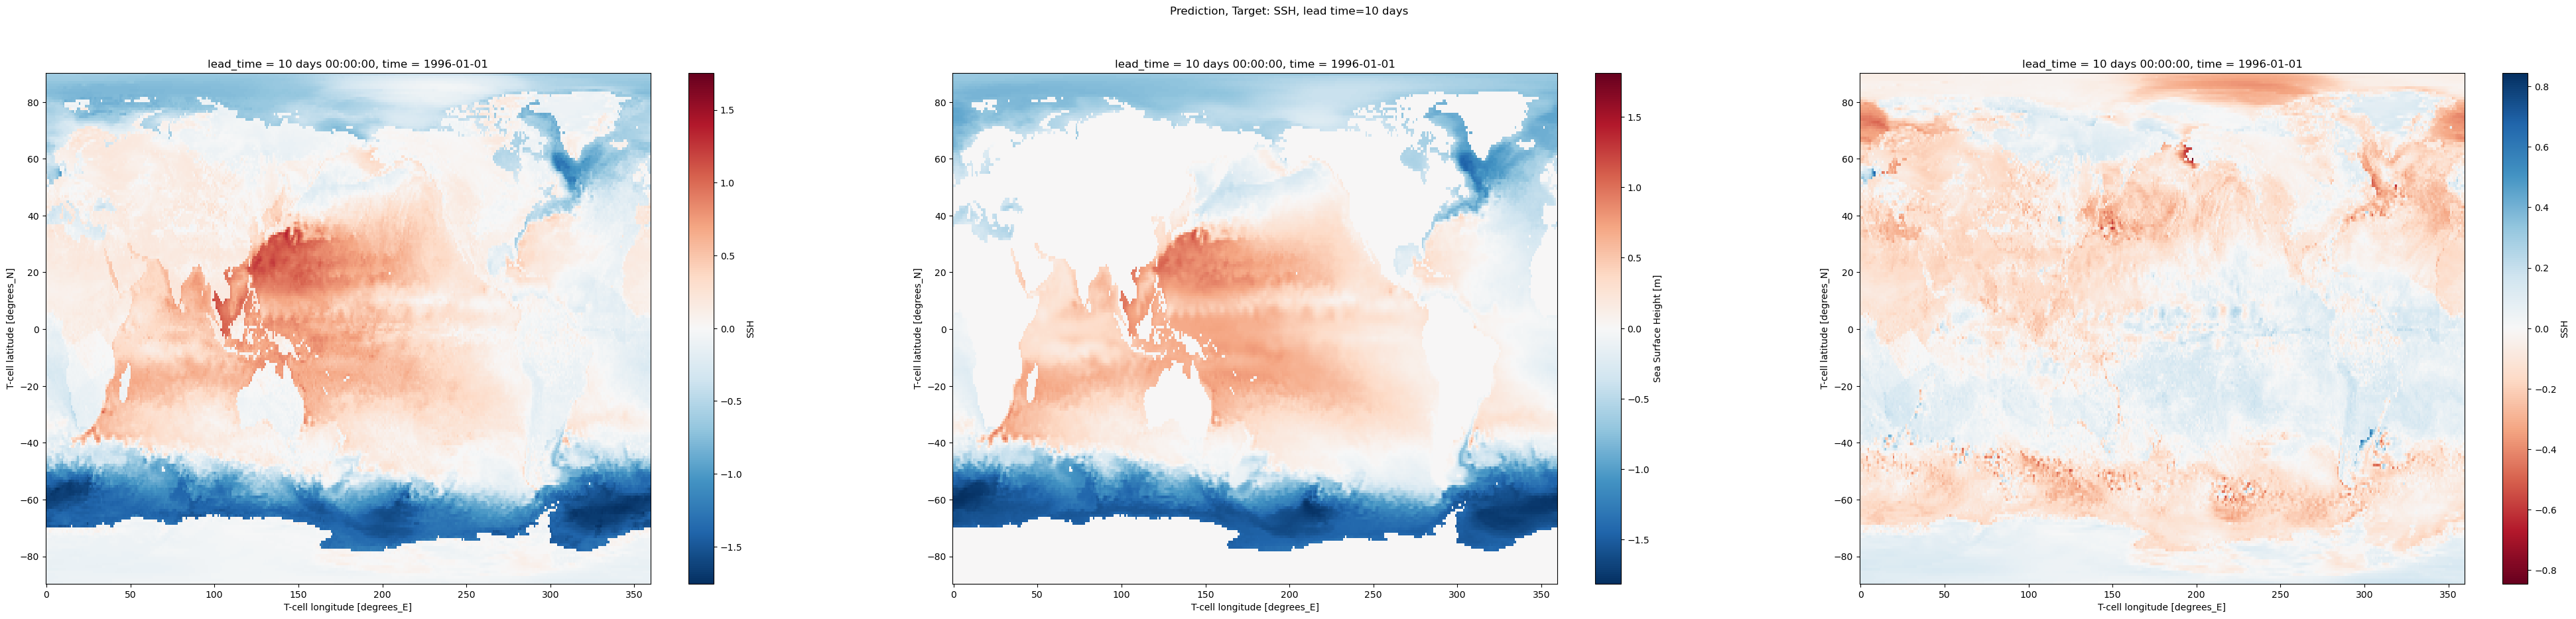

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(50,10))
predictions.SSH.isel(time=0, lead_time=-1).plot(ax=ax[0])
targets.SSH.isel(time=0, lead_time=-1).plot(ax=ax[1])
diff = targets.SSH.isel(time=0, lead_time=-1) - predictions.SSH.isel(time=0, lead_time=-1)
diff.plot(ax=ax[2], cmap='RdBu')
lead_time_days = predictions.lead_time[-1].values.astype('timedelta64[D]')
plt.suptitle(f'Prediction, Target: SSH, lead time={lead_time_days}')
plt.show()

## Sea Ice

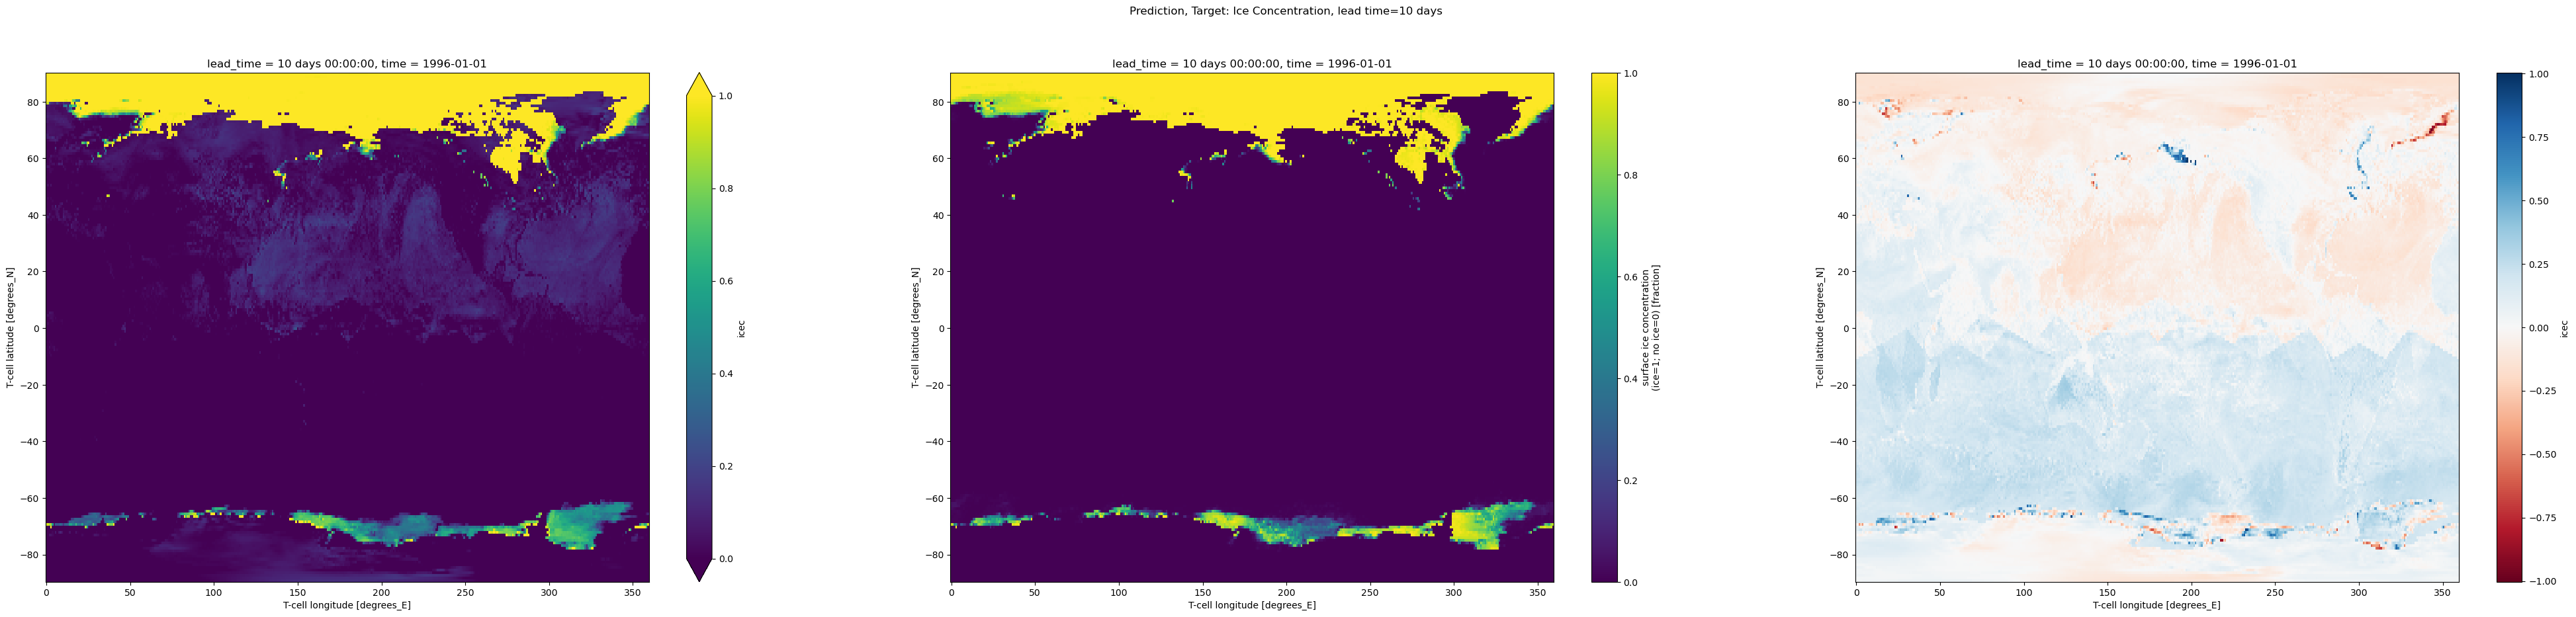

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(50,10))
predictions.icec.isel(time=0, lead_time=-1).plot(ax=ax[0], vmin=0, vmax=1, cmap="viridis")
targets.icec.isel(time=0, lead_time=-1).plot(ax=ax[1])
diff = targets.icec.isel(time=0, lead_time=-1) - predictions.icec.isel(time=0, lead_time=-1)
diff.plot(ax=ax[2], cmap='RdBu')
lead_time_days = predictions.lead_time[-1].values.astype('timedelta64[D]')
plt.suptitle(f'Prediction, Target: Ice Concentration, lead time={lead_time_days}')
plt.show()

## Soil Moisture

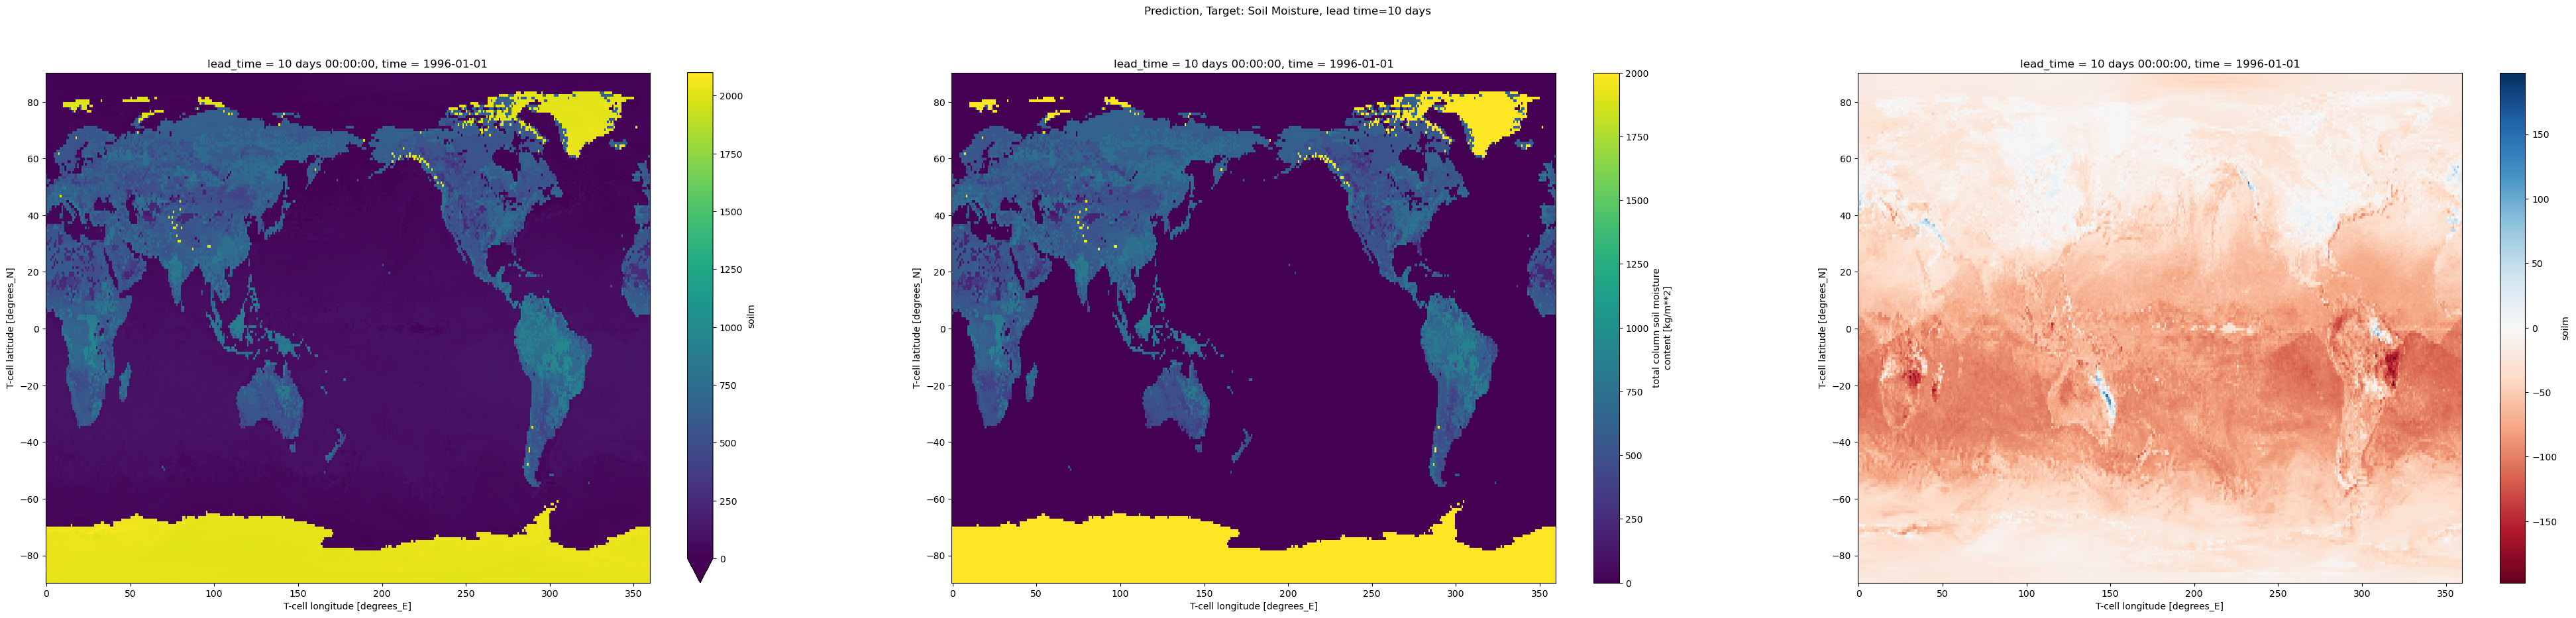

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(50,10))
predictions.soilm.isel(time=0, lead_time=-1).plot(ax=ax[0], cmap="viridis", vmin=0)
targets.soilm.isel(time=0, lead_time=-1).plot(ax=ax[1], cmap="viridis")
diff = targets.soilm.isel(time=0, lead_time=-1) - predictions.soilm.isel(time=0, lead_time=-1)
diff.plot(ax=ax[2], cmap='RdBu')
lead_time_days = predictions.lead_time[-1].values.astype('timedelta64[D]')
plt.suptitle(f'Prediction, Target: Soil Moisture, lead time={lead_time_days}')
plt.show()

## 3D ocean

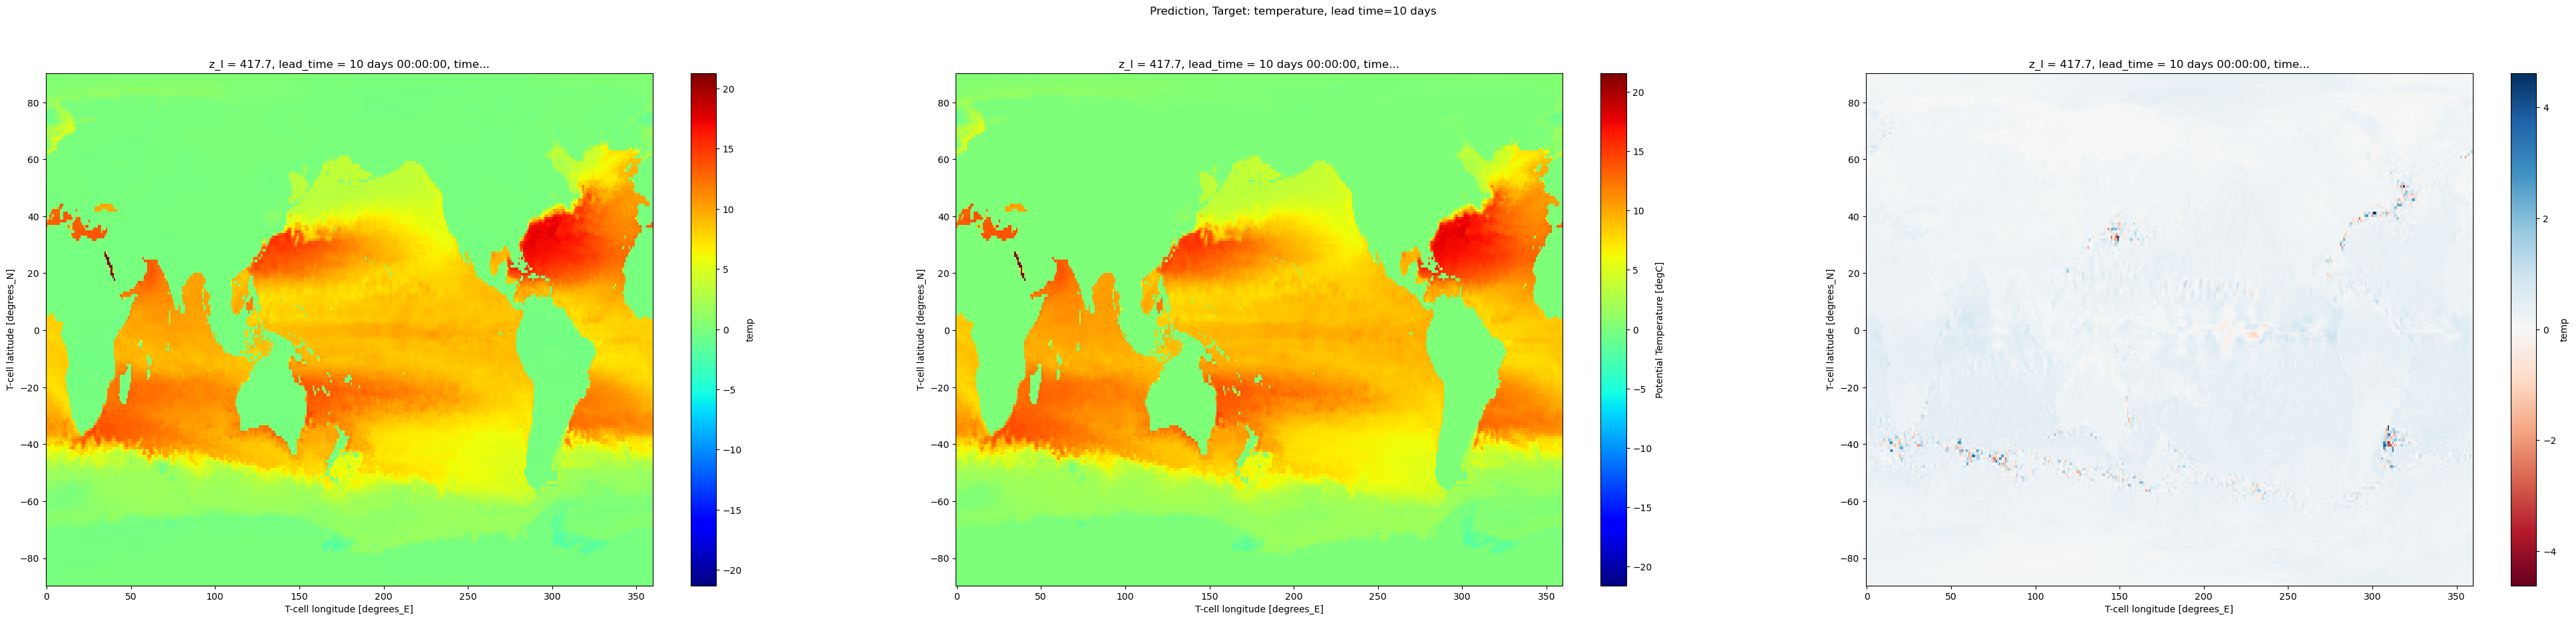

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(50,10))
predictions.temp.isel(time=0, lead_time=-1, z_l=-1).plot(ax=ax[0], cmap="jet")
targets.temp.isel(time=0, lead_time=-1, z_l=-1).plot(ax=ax[1], cmap="jet")
diff = targets.temp.isel(time=0, lead_time=-1, z_l=-1) - predictions.temp.isel(time=0, lead_time=-1, z_l=-1)
diff.plot(ax=ax[2], cmap='RdBu')
lead_time_days = predictions.lead_time[-1].values.astype('timedelta64[D]')
plt.suptitle(f'Prediction, Target: temperature, lead time={lead_time_days}')
plt.show()

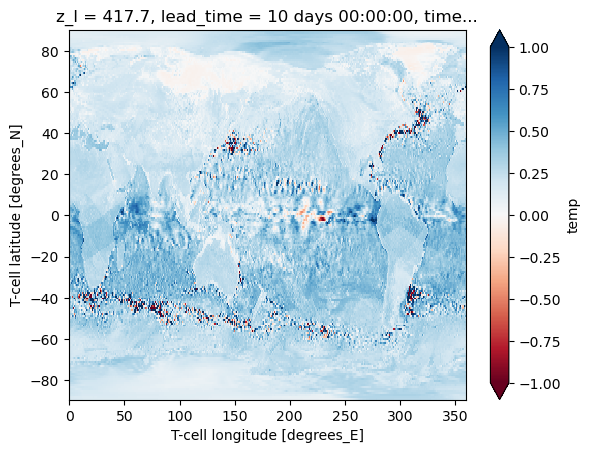

In [13]:
diff.plot(cmap='RdBu', vmin=-1, vmax=1)
plt.show()

In [31]:
print(predictions.lat[50].values)
print(predictions.lon[220].values)

42.979819538909815
206.25


In [35]:
predictions.soilm.isel(lat=50, lon=220, lead_time=-1).values

array([5.740899], dtype=float32)

In [34]:
targets.SSH.isel(lat=50, lon=220, lead_time=-1).values

array([0.08719323], dtype=float32)